In [1]:
CELL_TYPE = 'DC'
N_SPLITS: int = 5
N_TRIALS: int = 50
RUN_NAME: str = "studyID"

In [2]:
# Parameters
CELL_TYPE = "Plasma"


In [3]:
if RUN_NAME != "":
    RUN_NAME = RUN_NAME + "_"

In [4]:
import os
import sys
#from pyprojroot.here import here

import pandas as pd
import anndata as ad
import numpy as np
import math
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

import optuna

import joblib
import pickle
import datetime

import collections

import xgboost
from sklearn.preprocessing import LabelEncoder

import scipy.sparse as ssp
import joblib

from pyprojroot import here

from dotenv import load_dotenv

In [5]:
assert load_dotenv()

def here(fpath):
    return os.path.join(BUCKET_DIRPATH, fpath)

In [6]:
target_y = 'studyID'

# LOAD DATASET

In [7]:
adata = ad.read_h5ad(
    str(here(f'03_downstream_analysis/08_gene_importance/data/{CELL_TYPE}_adataMerged_SPECTRAgenes.log1p.h5ad')),
    backed='r',
    chunk_size=25000
)

In [8]:
adata.obs

,studyID,libraryID,sampleID,chemistry,disease,sex,binned_age,Level1,Level2
cellID,,,,,,,,,
SCGT02_L002_SEO112_T0_CAATTTCGTTTATGCG,SCGT02,SCGT02_L002,SCGT02_SEO112_T0,3_GEX_V3,healthy,male,51-60,Plasma,Plasma_IGHG
SCGT02_L002_SEO112_T0_GGGTCACGTGACCGAA,SCGT02,SCGT02_L002,SCGT02_SEO112_T0,3_GEX_V3,healthy,male,51-60,Plasma,Plasma_IGHA
Perez2022_L020_1297_T0_ATAGACCAGTGGCACA,Perez2022,Perez2022_L020,Perez2022_1297_T0,3_GEX_V2,SLE,female,51-60,Plasma,Plasma_IGHA
Perez2022_L065_2135_T0_AGAATAGGTGCACGAA,Perez2022,Perez2022_L065,Perez2022_2135_T0,3_GEX_V2,SLE,female,51-60,Plasma,Plasma_IGHA
Perez2022_L066_2135_T0_GGCAATTAGCTGGAAC,Perez2022,Perez2022_L066,Perez2022_2135_T0,3_GEX_V2,SLE,female,51-60,Plasma,Plasma_IGHA
...,...,...,...,...,...,...,...,...,...
Terekhova2023_L018_E07_T0_CTGATCCTCTGGTATG,Terekhova2023,Terekhova2023_L018,Terekhova2023_E07_T0,5_GEX_V2,healthy,male,71-80,Plasma,Plasma_IGHG
Terekhova2023_L018_E07_T0_GATCTAGAGCCCAACC,Terekhova2023,Terekhova2023_L018,Terekhova2023_E07_T0,5_GEX_V2,healthy,male,71-80,Plasma,Plasma_IGHA
Terekhova2023_L018_E07_T0_GTACTTTCATGGTCTA,Terekhova2023,Terekhova2023_L018,Terekhova2023_E07_T0,5_GEX_V2,healthy,male,71-80,Plasma,Plasma_XBP1


# EXTRACT INDEXES FOR DATA SPLITTING (STRATIFIED BY DISEASE, GROUPED BY PATIENT)

# EXTRACT CELL COUNTS PER SPLIT (TO MAKE SURE THAT RATIOS RESEMBLE 70:20:10)

In [9]:
all_idxs = np.arange(adata.obs.shape[0])
left_out_splits = [s[1] for s in StratifiedGroupKFold(n_splits=N_SPLITS).split(all_idxs, adata.obs[target_y], adata.obs.sampleID)]

min_stats = []
for val_fold_idx, test_fold_idx in product(range(N_SPLITS), range(1,N_SPLITS)):
    if val_fold_idx == test_fold_idx:
        continue

    all_idxs = np.arange(adata.obs.shape[0])
    val_idxs, test_idxs = left_out_splits[val_fold_idx], left_out_splits[test_fold_idx]
    train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

    cell_count_df = []
    cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
    cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
    cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
    cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
    cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)
    min_stats.append((val_fold_idx, test_fold_idx, cell_plot_data.query('split=="train"').value.min(), cell_plot_data.query('split=="test"').value.min()))

# CALCULATE RATIOS OF PATIENTS IN TRAINING AND TESTING SET: splits that best fit the expected ratios

In [10]:
split_rankings_df = (pd.DataFrame(min_stats, columns=['val_idx', 'test_idx', 'train_min', 'test_mean'])
 .assign(train_min = lambda df: df.train_min / df.train_min.max())
 .assign(test_mean = lambda df: df.test_mean / df.test_mean.max())
 .assign(ranking = lambda df: df.test_mean * df.train_min)
 .sort_values('ranking'))
split_rankings_df

,val_idx,test_idx,train_min,test_mean,ranking
14,4,2,0.485644,0.174603,0.084795
11,3,2,0.522197,0.174603,0.091177
1,0,2,0.553529,0.174603,0.096648
4,1,2,0.553529,0.174603,0.096648
7,2,1,0.553529,0.349206,0.193296
13,4,1,0.987448,0.349206,0.344823
10,3,1,0.995816,0.349206,0.347745
0,0,1,1.000000,0.349206,0.349206
8,2,3,0.522197,0.833333,0.435165
9,2,4,0.485644,1.000000,0.485644


In [11]:
best_split = split_rankings_df.loc[split_rankings_df['ranking'].idxmax()]
all_idxs = np.arange(adata.obs.shape[0])
val_idxs, test_idxs = left_out_splits[best_split.val_idx.astype(int)], left_out_splits[best_split.test_idx.astype(int)]
train_idxs = np.delete(all_idxs, np.union1d(val_idxs, test_idxs))

### CHECK NUMBER OF CELLS PER SPLIT

In [12]:
cell_count_df = []
cell_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='train'))
cell_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='val'))
cell_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).size().to_frame(name='cell_count').reset_index().assign(split='test'))
cell_count_df = pd.concat(cell_count_df).pivot(index=target_y, columns='split', values='cell_count')
cell_plot_data = cell_count_df.div(cell_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

pat_count_df = []
pat_count_df.append(adata.obs.iloc[train_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='train'))
pat_count_df.append(adata.obs.iloc[val_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='val'))
pat_count_df.append(adata.obs.iloc[test_idxs].groupby(target_y, observed=False).sampleID.nunique().to_frame(name='patient_count').reset_index().assign(split='test'))
pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pd.concat(pat_count_df).pivot(index=target_y, columns='split', values='patient_count')
pat_count_df = pat_count_df.div(pat_count_df.sum(axis=1), axis=0)
pat_plot_data = pat_count_df.div(pat_count_df.sum(axis=1), axis=0).reset_index().melt(id_vars=target_y)

train_pats = set(adata.obs.iloc[train_idxs].sampleID)
test_pats = set(adata.obs.iloc[test_idxs].sampleID)
val_pats = set(adata.obs.iloc[val_idxs].sampleID)

In [13]:
assert val_pats.intersection(test_pats) != {}
assert train_pats.intersection(test_pats) != {}
assert train_pats.intersection(val_pats) != {}

### PLOT PATIENT AND CELL DISTRIBUTION ACROSS TRAIN, TEST, AND VALIDATION SETS PER DISEASE
### CHECK THAT THEY APPROXIMATE EXPECTATION

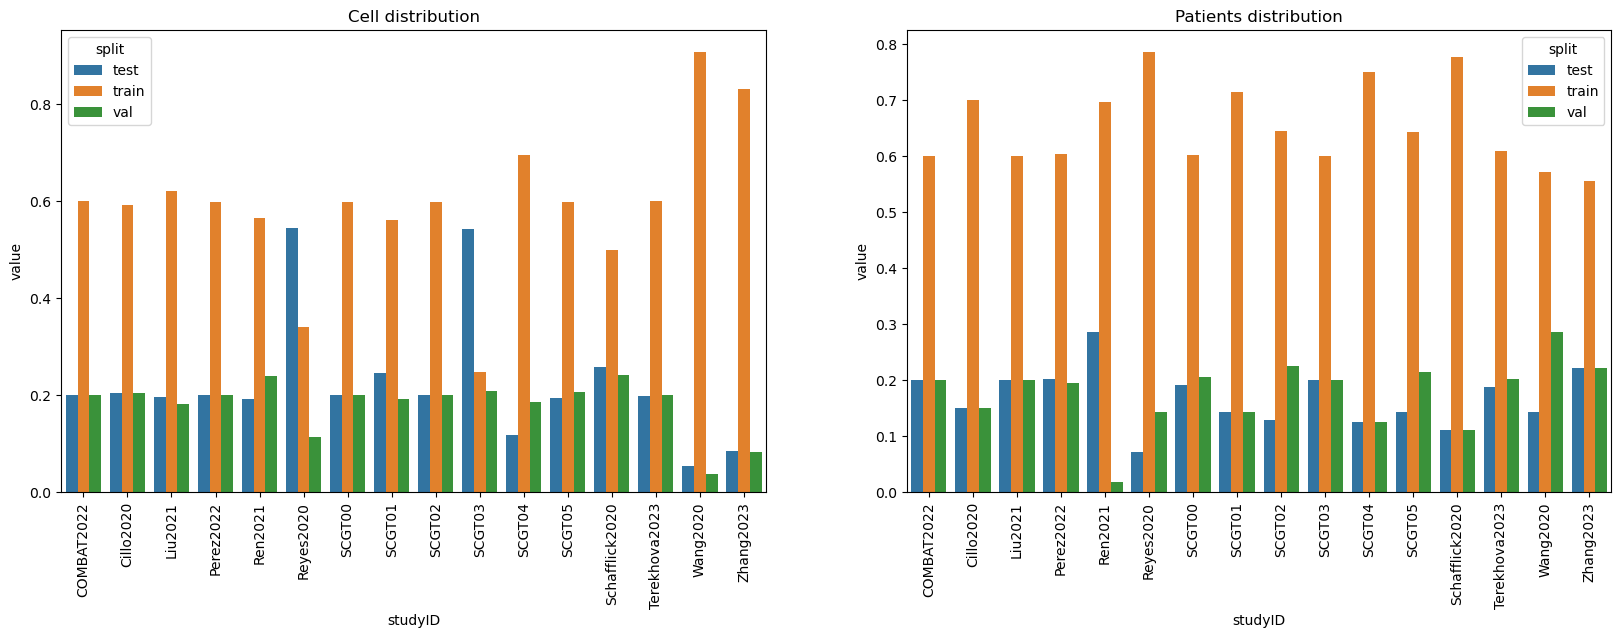

In [14]:
_, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.barplot(x=target_y, y='value', hue='split', data=cell_plot_data, ax=axs[0])
axs[0].set_title('Cell distribution')
axs[0].tick_params(axis='x', labelrotation=90)
sns.barplot(x=target_y, y='value', hue='split', data=pat_plot_data, ax=axs[1])
axs[1].set_title('Patients distribution')
axs[1].tick_params(axis='x', labelrotation=90)

os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/"), exist_ok=True)

plt.savefig(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/01_split_plots/{RUN_NAME}{CELL_TYPE}_split_quality.pdf'), bbox_inches='tight', dpi=300)

In [15]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/"), exist_ok=True)

np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_train_idxs.npy"), train_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_val_idxs.npy"), val_idxs)
np.save(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/02_preprocessing/{RUN_NAME}{CELL_TYPE}_test_idxs.npy"), test_idxs)

### SUBSET DATASET INTO TRAIN/TEST/VAL SPLITS

In [16]:
X_train = adata.X[train_idxs]
X_test = adata.X[test_idxs]
X_val = adata.X[val_idxs]
X_train.shape, X_test.shape, X_val.shape

((10475, 935), (3148, 935), (3231, 935))

In [17]:
y_train = adata.obs.iloc[train_idxs][target_y].values.astype(str)
y_test = adata.obs.iloc[test_idxs][target_y].values.astype(str)
y_val = adata.obs.iloc[val_idxs][target_y].values.astype(str)
y_train.shape, y_test.shape, y_val.shape 

((10475,), (3148,), (3231,))

In [18]:
lenc = LabelEncoder()
y_train_enc = lenc.fit_transform(y_train)
y_val_enc = lenc.transform(y_val)
y_test_enc = lenc.transform(y_test)

### GENERATE F1 

In [19]:
def custom_f1_score(y_true, y_pred):
    return -f1_score(y_true, y_pred.argmax(1), average='weighted')

In [20]:
eval_metric=custom_f1_score
eval_metric_name='custom_f1_score'

def objective(trial):
    params = {
        'sampling_method': 'gradient_based',
        'n_estimators': 1500,
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 250),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 5e-1, log=True),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-{eval_metric_name}')
    xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        early_stopping_rounds=20,
        callbacks=[pruning_callback],
        **params
    )
    xgb.fit(
        X_train, 
        y_train_enc, 
        verbose=0,
        eval_set=[(X_val, y_val_enc)],
    )
    trial.set_user_attr('best_iteration', xgb.best_iteration)

    return xgb.best_score

In [21]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='minimize', sampler=sampler)
wandb_kwargs = {"project": "xgboost", "name": f"{RUN_NAME}{CELL_TYPE}"}
wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
study.optimize(objective, n_trials=N_TRIALS, callbacks=[wandbc], gc_after_trial=True)

[I 2025-03-18 17:35:19,282] A new study created in memory with name: no-name-7c61e040-c26e-49b3-a090-e4b51b6b910c


/tmp/ipykernel_1729967/350114600.py:4: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = optuna.integration.WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: dav1989 (inflammation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Tracking run with wandb version 0.19.8


wandb: Run data is saved locally in /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/wandb/run-20250318_173522-4pszdt5y
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run studyID_Plasma


wandb: ⭐️ View project at https://wandb.ai/inflammation/xgboost


wandb: 🚀 View run at https://wandb.ai/inflammation/xgboost/runs/4pszdt5y


[I 2025-03-18 17:35:30,093] Trial 0 finished with value: -0.801242 and parameters: {'max_depth': 9, 'min_child_weight': 238, 'subsample': 0.7587945476302645, 'colsample_bynode': 0.6387926357773329, 'learning_rate': 0.0026368755339723046}. Best is trial 0 with value: -0.801242.


[I 2025-03-18 17:35:38,700] Trial 1 finished with value: -0.986014 and parameters: {'max_depth': 5, 'min_child_weight': 15, 'subsample': 0.8795585311974417, 'colsample_bynode': 0.6410035105688879, 'learning_rate': 0.08148293210105287}. Best is trial 1 with value: -0.986014.


[I 2025-03-18 17:35:40,289] Trial 2 finished with value: -0.748603 and parameters: {'max_depth': 3, 'min_child_weight': 243, 'subsample': 0.8491983767203796, 'colsample_bynode': 0.29110519961044856, 'learning_rate': 0.003095566460242371}. Best is trial 1 with value: -0.986014.


[I 2025-03-18 17:36:03,779] Trial 3 finished with value: -0.933647 and parameters: {'max_depth': 6, 'min_child_weight': 77, 'subsample': 0.5722807884690141, 'colsample_bynode': 0.48875051677790415, 'learning_rate': 0.006109683510122491}. Best is trial 1 with value: -0.986014.


[I 2025-03-18 17:36:22,343] Trial 4 finished with value: -0.971124 and parameters: {'max_depth': 14, 'min_child_weight': 35, 'subsample': 0.3629301836816964, 'colsample_bynode': 0.4297256589643226, 'learning_rate': 0.01701841881702917}. Best is trial 1 with value: -0.986014.


[I 2025-03-18 17:36:23,074] Trial 5 pruned. Trial was pruned at iteration 3.


[I 2025-03-18 17:36:27,715] Trial 6 finished with value: -0.965144 and parameters: {'max_depth': 13, 'min_child_weight': 43, 'subsample': 0.1585464336867516, 'colsample_bynode': 0.9539969835279999, 'learning_rate': 0.4038423798071558}. Best is trial 1 with value: -0.986014.


[I 2025-03-18 17:36:28,694] Trial 7 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:36:29,778] Trial 8 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:36:30,375] Trial 9 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:36:39,939] Trial 10 finished with value: -0.989727 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9725833997090791, 'colsample_bynode': 0.11616568805333755, 'learning_rate': 0.17780618353487967}. Best is trial 10 with value: -0.989727.


[I 2025-03-18 17:36:48,720] Trial 11 finished with value: -0.987546 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.9818290990185045, 'colsample_bynode': 0.17702656156719, 'learning_rate': 0.11568531411766632}. Best is trial 10 with value: -0.989727.


[I 2025-03-18 17:36:54,992] Trial 12 finished with value: -0.987698 and parameters: {'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9762317723681219, 'colsample_bynode': 0.1303670507685675, 'learning_rate': 0.14353293664472047}. Best is trial 10 with value: -0.989727.


[I 2025-03-18 17:36:55,904] Trial 13 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:36:56,996] Trial 14 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:01,789] Trial 15 finished with value: -0.98469 and parameters: {'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.7161698798894325, 'colsample_bynode': 0.31554979471905614, 'learning_rate': 0.1972373617578196}. Best is trial 10 with value: -0.989727.


[I 2025-03-18 17:37:02,759] Trial 16 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:03,844] Trial 17 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:04,740] Trial 18 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:05,327] Trial 19 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:06,298] Trial 20 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:15,389] Trial 21 finished with value: -0.99035 and parameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9774164828325145, 'colsample_bynode': 0.19119727298237837, 'learning_rate': 0.1215402030808754}. Best is trial 21 with value: -0.99035.


[I 2025-03-18 17:37:16,207] Trial 22 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:17,274] Trial 23 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:25,270] Trial 24 finished with value: -0.990631 and parameters: {'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.9371340199057098, 'colsample_bynode': 0.3570727728603251, 'learning_rate': 0.11462176450007101}. Best is trial 24 with value: -0.990631.


[I 2025-03-18 17:37:25,848] Trial 25 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:26,717] Trial 26 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:27,768] Trial 27 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:28,833] Trial 28 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:29,505] Trial 29 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:30,316] Trial 30 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:37,608] Trial 31 finished with value: -0.989586 and parameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9966476301986823, 'colsample_bynode': 0.15535588853847576, 'learning_rate': 0.12230555735386052}. Best is trial 24 with value: -0.990631.


[I 2025-03-18 17:37:38,587] Trial 32 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:39,614] Trial 33 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:40,217] Trial 34 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:44,102] Trial 35 finished with value: -0.986234 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9994721446789168, 'colsample_bynode': 0.25104139007510584, 'learning_rate': 0.28339956427375135}. Best is trial 24 with value: -0.990631.


[I 2025-03-18 17:37:45,247] Trial 36 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:46,256] Trial 37 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:47,242] Trial 38 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:47,902] Trial 39 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:48,476] Trial 40 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:49,599] Trial 41 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:50,784] Trial 42 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:51,878] Trial 43 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:52,489] Trial 44 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:56,319] Trial 45 pruned. Trial was pruned at iteration 24.


[I 2025-03-18 17:37:57,451] Trial 46 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:58,325] Trial 47 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:37:59,448] Trial 48 pruned. Trial was pruned at iteration 0.


[I 2025-03-18 17:38:00,132] Trial 49 pruned. Trial was pruned at iteration 0.


In [22]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/"), exist_ok=True)

joblib.dump(study, here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/study/{RUN_NAME}{CELL_TYPE}_xgboost.pkl'))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/study/studyID_Plasma_xgboost.pkl']

In [23]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/"), exist_ok=True)

fig = optuna.visualization.plot_parallel_coordinate(study)
fig.write_image(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/parallel_coordinate/{RUN_NAME}{CELL_TYPE}_pcoord.pdf'))

In [24]:
n_estimators = int(study.best_trial.user_attrs['best_iteration']*1.2)
xgb = xgboost.XGBClassifier(
        device='gpu',
        eval_metric=eval_metric,
        n_estimators=n_estimators,
        **study.best_trial.params
    )
xgb.fit(
    ssp.vstack((X_train, X_val)), 
    np.concatenate((y_train_enc, y_val_enc)), 
    eval_set=[(X_test, y_test_enc)],
    verbose=1,
)

[0]	validation_0-mlogloss:2.03324	validation_0-custom_f1_score:-0.89349


[1]	validation_0-mlogloss:1.69998	validation_0-custom_f1_score:-0.91095


[2]	validation_0-mlogloss:1.46676	validation_0-custom_f1_score:-0.92227


[3]	validation_0-mlogloss:1.28851	validation_0-custom_f1_score:-0.92895


[4]	validation_0-mlogloss:1.14385	validation_0-custom_f1_score:-0.93359


[5]	validation_0-mlogloss:1.02149	validation_0-custom_f1_score:-0.93850


[6]	validation_0-mlogloss:0.91955	validation_0-custom_f1_score:-0.94399


[7]	validation_0-mlogloss:0.83355	validation_0-custom_f1_score:-0.94610


[8]	validation_0-mlogloss:0.75636	validation_0-custom_f1_score:-0.94866


[9]	validation_0-mlogloss:0.68961	validation_0-custom_f1_score:-0.94818


[10]	validation_0-mlogloss:0.63013	validation_0-custom_f1_score:-0.95241


[11]	validation_0-mlogloss:0.57760	validation_0-custom_f1_score:-0.95445


[12]	validation_0-mlogloss:0.53076	validation_0-custom_f1_score:-0.95542


[13]	validation_0-mlogloss:0.49035	validation_0-custom_f1_score:-0.95535


[14]	validation_0-mlogloss:0.45212	validation_0-custom_f1_score:-0.95634


[15]	validation_0-mlogloss:0.41911	validation_0-custom_f1_score:-0.95859


[16]	validation_0-mlogloss:0.38926	validation_0-custom_f1_score:-0.95831


[17]	validation_0-mlogloss:0.36225	validation_0-custom_f1_score:-0.95836


[18]	validation_0-mlogloss:0.33804	validation_0-custom_f1_score:-0.95871


[19]	validation_0-mlogloss:0.31650	validation_0-custom_f1_score:-0.95907


[20]	validation_0-mlogloss:0.29723	validation_0-custom_f1_score:-0.95981


[21]	validation_0-mlogloss:0.28005	validation_0-custom_f1_score:-0.95914


[22]	validation_0-mlogloss:0.26402	validation_0-custom_f1_score:-0.95964


[23]	validation_0-mlogloss:0.24976	validation_0-custom_f1_score:-0.96060


[24]	validation_0-mlogloss:0.23645	validation_0-custom_f1_score:-0.96194


[25]	validation_0-mlogloss:0.22550	validation_0-custom_f1_score:-0.96085


[26]	validation_0-mlogloss:0.21504	validation_0-custom_f1_score:-0.96250


[27]	validation_0-mlogloss:0.20494	validation_0-custom_f1_score:-0.96292


[28]	validation_0-mlogloss:0.19569	validation_0-custom_f1_score:-0.96324


[29]	validation_0-mlogloss:0.18749	validation_0-custom_f1_score:-0.96324


[30]	validation_0-mlogloss:0.18055	validation_0-custom_f1_score:-0.96356


[31]	validation_0-mlogloss:0.17398	validation_0-custom_f1_score:-0.96354


[32]	validation_0-mlogloss:0.16818	validation_0-custom_f1_score:-0.96311


[33]	validation_0-mlogloss:0.16168	validation_0-custom_f1_score:-0.96471


[34]	validation_0-mlogloss:0.15671	validation_0-custom_f1_score:-0.96503


[35]	validation_0-mlogloss:0.15165	validation_0-custom_f1_score:-0.96470


[36]	validation_0-mlogloss:0.14729	validation_0-custom_f1_score:-0.96487


[37]	validation_0-mlogloss:0.14347	validation_0-custom_f1_score:-0.96535


[38]	validation_0-mlogloss:0.14000	validation_0-custom_f1_score:-0.96469


[39]	validation_0-mlogloss:0.13729	validation_0-custom_f1_score:-0.96469


[40]	validation_0-mlogloss:0.13469	validation_0-custom_f1_score:-0.96503


[41]	validation_0-mlogloss:0.13219	validation_0-custom_f1_score:-0.96541


[42]	validation_0-mlogloss:0.12938	validation_0-custom_f1_score:-0.96574


[43]	validation_0-mlogloss:0.12706	validation_0-custom_f1_score:-0.96524


[44]	validation_0-mlogloss:0.12472	validation_0-custom_f1_score:-0.96524


[45]	validation_0-mlogloss:0.12236	validation_0-custom_f1_score:-0.96588


[46]	validation_0-mlogloss:0.12021	validation_0-custom_f1_score:-0.96679


[47]	validation_0-mlogloss:0.11846	validation_0-custom_f1_score:-0.96706


[48]	validation_0-mlogloss:0.11752	validation_0-custom_f1_score:-0.96789


[49]	validation_0-mlogloss:0.11575	validation_0-custom_f1_score:-0.96855


[50]	validation_0-mlogloss:0.11507	validation_0-custom_f1_score:-0.96693


[51]	validation_0-mlogloss:0.11377	validation_0-custom_f1_score:-0.96735


[52]	validation_0-mlogloss:0.11229	validation_0-custom_f1_score:-0.96843


[53]	validation_0-mlogloss:0.11197	validation_0-custom_f1_score:-0.96760


[54]	validation_0-mlogloss:0.11085	validation_0-custom_f1_score:-0.96734


[55]	validation_0-mlogloss:0.11035	validation_0-custom_f1_score:-0.96735


[56]	validation_0-mlogloss:0.10982	validation_0-custom_f1_score:-0.96693


[57]	validation_0-mlogloss:0.10909	validation_0-custom_f1_score:-0.96734


[58]	validation_0-mlogloss:0.10850	validation_0-custom_f1_score:-0.96728


[59]	validation_0-mlogloss:0.10798	validation_0-custom_f1_score:-0.96718


[60]	validation_0-mlogloss:0.10756	validation_0-custom_f1_score:-0.96718


[61]	validation_0-mlogloss:0.10716	validation_0-custom_f1_score:-0.96759


[62]	validation_0-mlogloss:0.10626	validation_0-custom_f1_score:-0.96759


[63]	validation_0-mlogloss:0.10552	validation_0-custom_f1_score:-0.96728


[64]	validation_0-mlogloss:0.10454	validation_0-custom_f1_score:-0.96728


[65]	validation_0-mlogloss:0.10363	validation_0-custom_f1_score:-0.96759


[66]	validation_0-mlogloss:0.10265	validation_0-custom_f1_score:-0.96759


[67]	validation_0-mlogloss:0.10238	validation_0-custom_f1_score:-0.96801


[68]	validation_0-mlogloss:0.10150	validation_0-custom_f1_score:-0.96801


[69]	validation_0-mlogloss:0.10114	validation_0-custom_f1_score:-0.96802


[70]	validation_0-mlogloss:0.10031	validation_0-custom_f1_score:-0.96802


[71]	validation_0-mlogloss:0.10064	validation_0-custom_f1_score:-0.96760


[72]	validation_0-mlogloss:0.10096	validation_0-custom_f1_score:-0.96729


[73]	validation_0-mlogloss:0.10096	validation_0-custom_f1_score:-0.96760


[74]	validation_0-mlogloss:0.10099	validation_0-custom_f1_score:-0.96760

[75]	validation_0-mlogloss:0.10136	validation_0-custom_f1_score:-0.96760


[76]	validation_0-mlogloss:0.10162	validation_0-custom_f1_score:-0.96729


[77]	validation_0-mlogloss:0.10196	validation_0-custom_f1_score:-0.96729


[78]	validation_0-mlogloss:0.10165	validation_0-custom_f1_score:-0.96760


[79]	validation_0-mlogloss:0.10143	validation_0-custom_f1_score:-0.96760


[80]	validation_0-mlogloss:0.10070	validation_0-custom_f1_score:-0.96760


[81]	validation_0-mlogloss:0.10105	validation_0-custom_f1_score:-0.96760


[82]	validation_0-mlogloss:0.10119	validation_0-custom_f1_score:-0.96760


[83]	validation_0-mlogloss:0.10155	validation_0-custom_f1_score:-0.96760


[84]	validation_0-mlogloss:0.10177	validation_0-custom_f1_score:-0.96760


[85]	validation_0-mlogloss:0.10212	validation_0-custom_f1_score:-0.96760


[86]	validation_0-mlogloss:0.10223	validation_0-custom_f1_score:-0.96760


[87]	validation_0-mlogloss:0.10213	validation_0-custom_f1_score:-0.96793


[88]	validation_0-mlogloss:0.10219	validation_0-custom_f1_score:-0.96793


[89]	validation_0-mlogloss:0.10233	validation_0-custom_f1_score:-0.96793


[90]	validation_0-mlogloss:0.10240	validation_0-custom_f1_score:-0.96793


[91]	validation_0-mlogloss:0.10224	validation_0-custom_f1_score:-0.96793


[92]	validation_0-mlogloss:0.10216	validation_0-custom_f1_score:-0.96793


[93]	validation_0-mlogloss:0.10194	validation_0-custom_f1_score:-0.96793


[94]	validation_0-mlogloss:0.10200	validation_0-custom_f1_score:-0.96793


[95]	validation_0-mlogloss:0.10186	validation_0-custom_f1_score:-0.96793


[96]	validation_0-mlogloss:0.10173	validation_0-custom_f1_score:-0.96793


[97]	validation_0-mlogloss:0.10160	validation_0-custom_f1_score:-0.96793


[98]	validation_0-mlogloss:0.10154	validation_0-custom_f1_score:-0.96793


[99]	validation_0-mlogloss:0.10153	validation_0-custom_f1_score:-0.96793


[100]	validation_0-mlogloss:0.10134	validation_0-custom_f1_score:-0.96793


[101]	validation_0-mlogloss:0.10114	validation_0-custom_f1_score:-0.96793


[102]	validation_0-mlogloss:0.10097	validation_0-custom_f1_score:-0.96793


[103]	validation_0-mlogloss:0.10111	validation_0-custom_f1_score:-0.96794


[104]	validation_0-mlogloss:0.10113	validation_0-custom_f1_score:-0.96761


[105]	validation_0-mlogloss:0.10092	validation_0-custom_f1_score:-0.96761


[106]	validation_0-mlogloss:0.10098	validation_0-custom_f1_score:-0.96761


[107]	validation_0-mlogloss:0.10084	validation_0-custom_f1_score:-0.96794


[108]	validation_0-mlogloss:0.10081	validation_0-custom_f1_score:-0.96794


[109]	validation_0-mlogloss:0.10067	validation_0-custom_f1_score:-0.96794


[110]	validation_0-mlogloss:0.10055	validation_0-custom_f1_score:-0.96794


[111]	validation_0-mlogloss:0.10058	validation_0-custom_f1_score:-0.96794


[112]	validation_0-mlogloss:0.10047	validation_0-custom_f1_score:-0.96794


[113]	validation_0-mlogloss:0.10042	validation_0-custom_f1_score:-0.96794


[114]	validation_0-mlogloss:0.10026	validation_0-custom_f1_score:-0.96794


[115]	validation_0-mlogloss:0.10014	validation_0-custom_f1_score:-0.96794


[116]	validation_0-mlogloss:0.10024	validation_0-custom_f1_score:-0.96794


[117]	validation_0-mlogloss:0.10016	validation_0-custom_f1_score:-0.96794


[118]	validation_0-mlogloss:0.10019	validation_0-custom_f1_score:-0.96794


[119]	validation_0-mlogloss:0.10012	validation_0-custom_f1_score:-0.96794


[120]	validation_0-mlogloss:0.10019	validation_0-custom_f1_score:-0.96794


[121]	validation_0-mlogloss:0.10022	validation_0-custom_f1_score:-0.96794


[122]	validation_0-mlogloss:0.10022	validation_0-custom_f1_score:-0.96794


[123]	validation_0-mlogloss:0.10000	validation_0-custom_f1_score:-0.96794


[124]	validation_0-mlogloss:0.09986	validation_0-custom_f1_score:-0.96794

[125]	validation_0-mlogloss:0.09983	validation_0-custom_f1_score:-0.96794


[126]	validation_0-mlogloss:0.09960	validation_0-custom_f1_score:-0.96794


[127]	validation_0-mlogloss:0.09954	validation_0-custom_f1_score:-0.96794


[128]	validation_0-mlogloss:0.09940	validation_0-custom_f1_score:-0.96794


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.3570727728603251,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function custom_f1_score at 0x7dc632537240>,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11462176450007101, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=129, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [25]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/"), exist_ok=True)

joblib.dump(xgb, (here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/best_model/{RUN_NAME}{CELL_TYPE}_xgb.json')))

['/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_gene_importance/results/targetY_studyID/03_xgboost/best_model/studyID_Plasma_xgb.json']

In [26]:
os.makedirs(here(f"03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/"), exist_ok=True)

(pd.DataFrame(np.array((y_test, y_test_enc, xgb.predict(X_test))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_test.zip')))
(pd.DataFrame(np.array((y_train, y_train_enc, xgb.predict(X_train))).T, columns=['y_true', 'y_true_code', 'y_pred'])
 .to_csv(here(f'03_downstream_analysis/08_gene_importance/results/targetY_{target_y}/03_xgboost/predictions/{RUN_NAME}{CELL_TYPE}_pred_train.zip')))

/scratch_isilon/groups/singlecell/shared/conda_env/xgboostGPU/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[17:38:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076482591/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


